# Intro

The main goal of the script is to measure the quality of the state embeddings.

States encode the following set of information:

- emission distribution (in particular, the mean value of the gaussian)
- co-occurrence probabilities (based on the transition matrix)

Thus we can look at the state IDs in two ways:

- states simplify the emission values (the state encodes values of a continuous distribution)
- state extends the information given by emissions by the relationship between each set of values (transition probabilities)

What we expect to infer from state embeddings and daily state series:

- day/night schedule
- workday/weekend (or holiday)


## Evaluation proposed

1. Cluster state embeddings (2 clusters, expectation: day/night)
2. Classify workday/weekend based on emission/state ID/embeddings daily sequences (we expect that embeddings will provide more relevant information)


# Build model

In [152]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import holidays
from IPython.display import display, Markdown, Latex, HTML
from sklearn.cluster import KMeans
from models_gaussian_2d import *
from eval_utils import *

# Setup
plt.rcParams.update({'figure.figsize': (20, 8)})
interval = 24 * 7 * 6

n = 4
l = 3
lr = 0.03271365590433669
ITER = 714450


lr = 0.1
ITER = 70000

TOLERANCE = 1e-4

In [153]:
# Data
df_main = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
df_main = df_main.ffill()
df_main["V_delta"] = (np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist()))
df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0
df_main["V_delta"] = df_main["V_delta"].rolling(6, center=True, min_periods=2).mean()

time_range = pd.DataFrame({"mtime":pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.min(), df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.max(), 24*6*365)})
df_main = pd.merge(time_range, df_main, on="mtime", how="left")

df_main["V_delta"] = (df_main["V_delta"].bfill().ffill() + df_main["V_delta"].ffill().bfill()) / 2
# df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()


seasonal_changes = df_main.V_delta.rolling(interval * 6, center=True, min_periods=2).mean() \
    .rolling(interval, center=True, min_periods=2).mean()[(df_main.mtime.dt.year == 2019)]

data = df_main.V_delta[(df_main.mtime.dt.year == 2019)] - seasonal_changes

lengths = np.array([interval for _ in range(data.shape[0] // (interval))] + [
    data.shape[0] - (data.shape[0] // (interval)) * interval])
Y_true = data.values.reshape(-1, 1)

In [154]:
Y_true

array([[-6.06411385],
       [-5.89740835],
       [-5.89737085],
       ...,
       [-5.84685301],
       [-5.84673234],
       [-6.34661658]])

In [155]:
def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",
        "save_code": True,
        "group": f"first-runs-2",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": n,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": None,
        "lr": lr,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

In [156]:
# Model
hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                log_config={'metrics_after_convergence': True})
densehmm = GaussianDenseHMM(n, mstep_config=mstep_cofig,
                            covariance_type='full', opt_schemes={"cooc"},
                            logging_monitor=hmm_monitor,
                            init_params="stmc", params="stmc", early_stopping=True)

start = time.perf_counter()
densehmm.fit_coocs(Y_true,lengths)
time_tmp = time.perf_counter() - start

omage_dtv,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
omage_dtv,0.0017
time,113.00083
total_log_prob,-151718.36802


         1     -189208.1241             +nan
         2     -168379.9089      +20828.2152
         3     -157952.5980      +10427.3109
         4     -162410.3960       -4457.7980
         5     -165604.1847       -3193.7887
         6     -167437.9842       -1833.7995
         7     -168540.5544       -1102.5702
         8     -169214.0101        -673.4557
         9     -169608.3246        -394.3145
        10     -169804.2441        -195.9195
        11     -169847.3227         -43.0786
        12     -169763.5693         +83.7534
        13     -169567.5563        +196.0130
        14     -169266.9756        +300.5807
        15     -168865.3060        +401.6696
        16     -168363.3866        +501.9194
        17     -167760.3272        +603.0594
        18     -167054.0096        +706.3176
        19     -166241.3429        +812.6667
        20     -165318.3845        +922.9584
        21     -164280.4156       +1037.9689
        22     -163122.0574       +1158.3582
        23

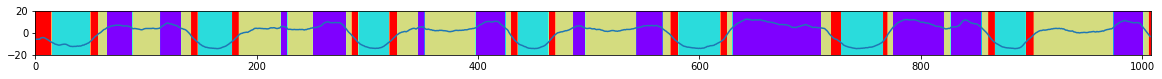

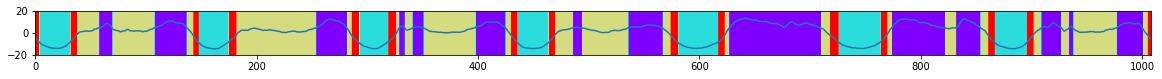

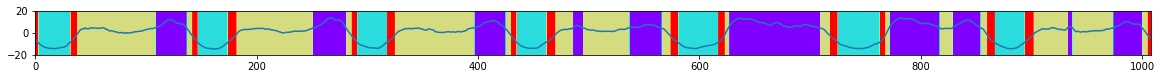

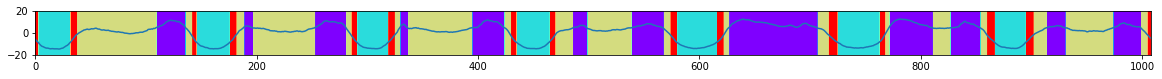

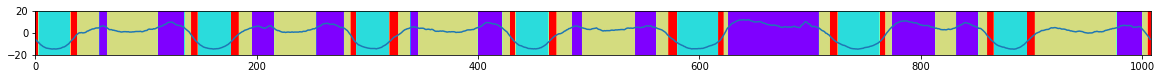

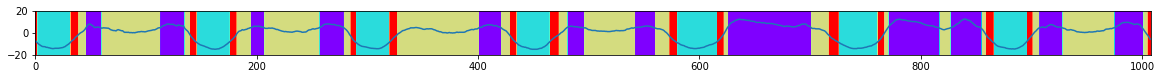

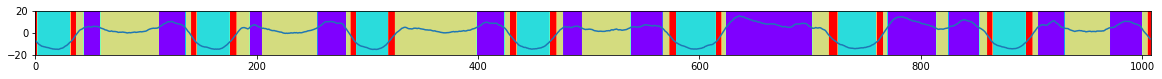

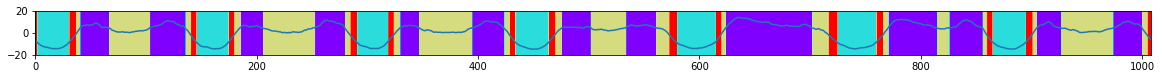

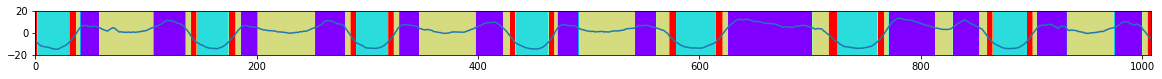

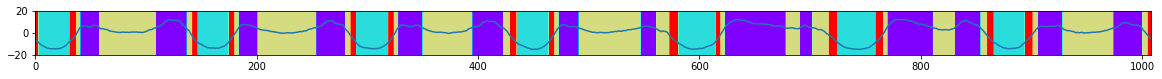

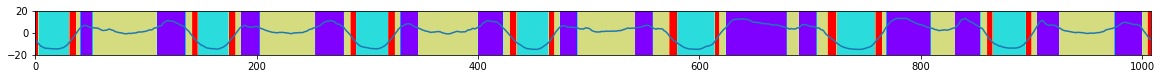

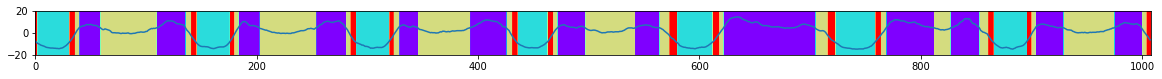

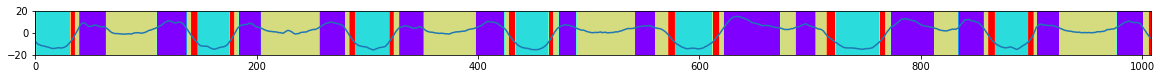

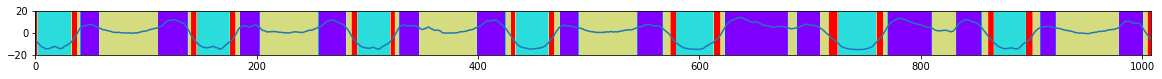

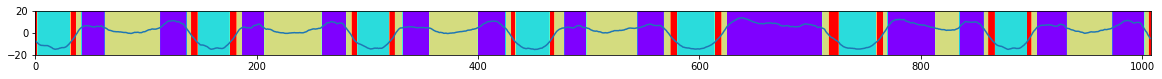

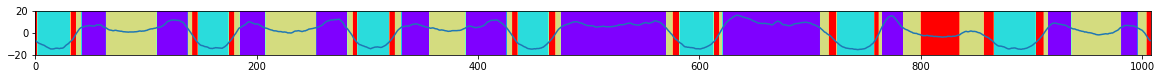

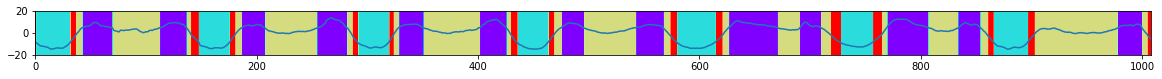

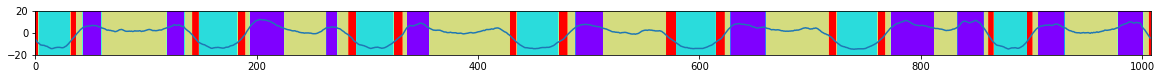

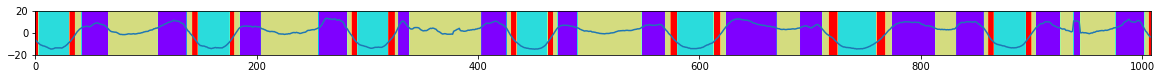

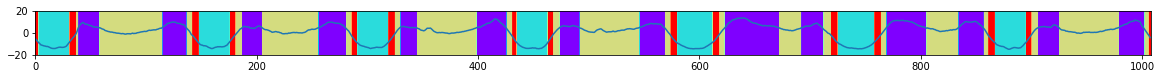

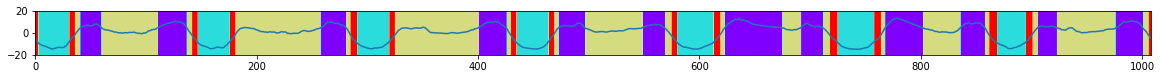

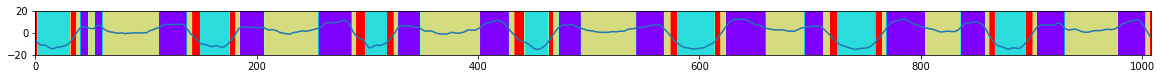

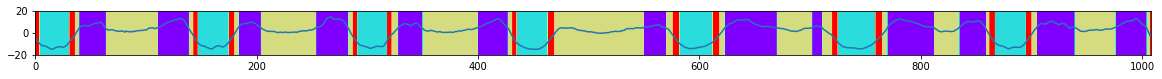

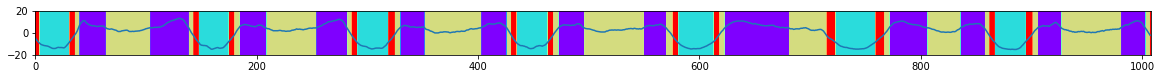

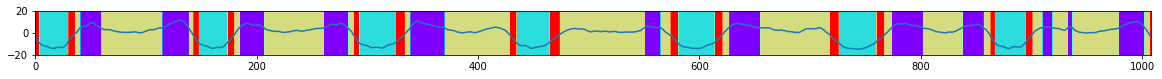

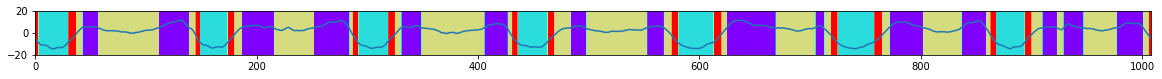

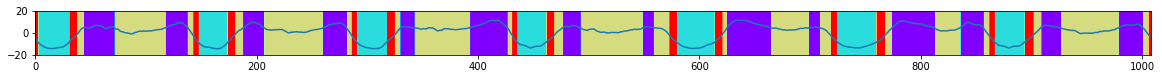

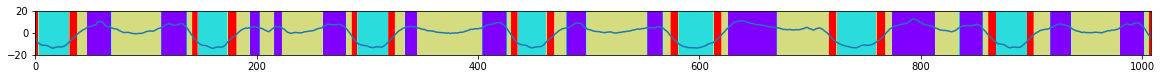

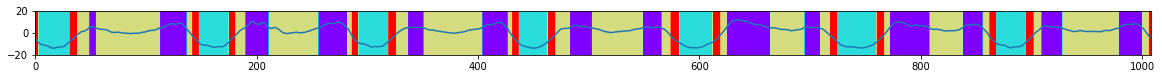

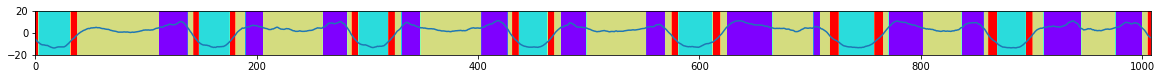

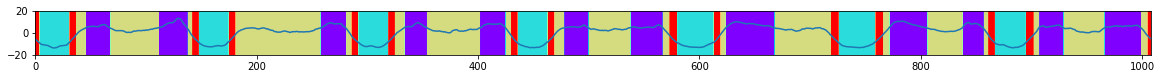

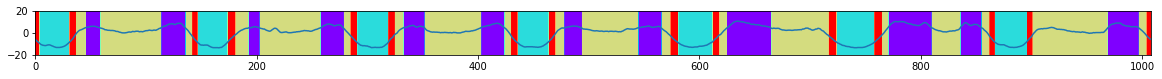

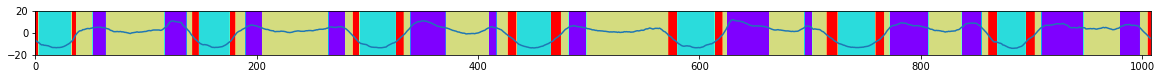

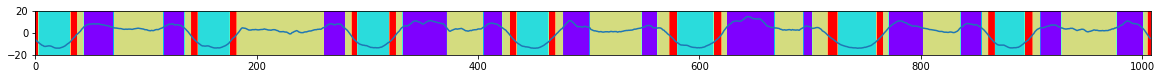

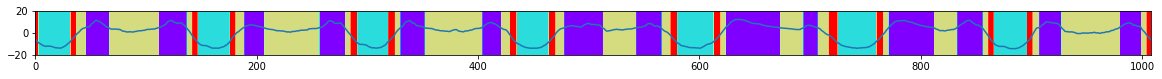

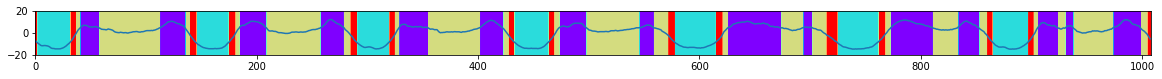

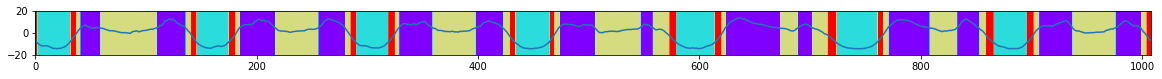

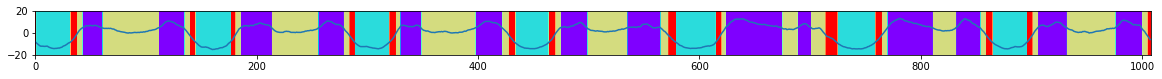

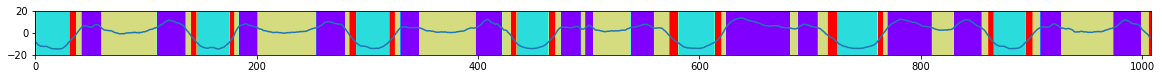

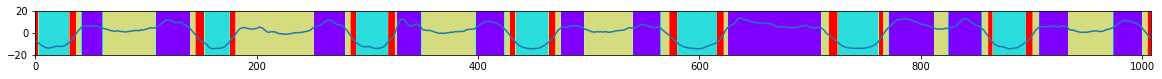

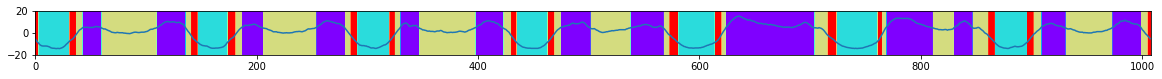

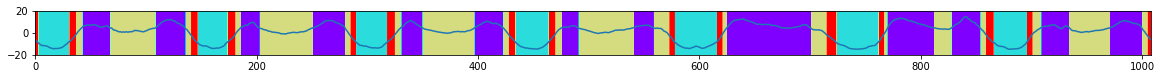

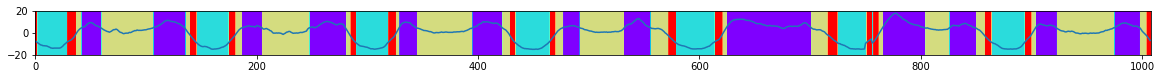

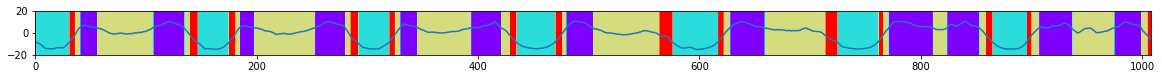

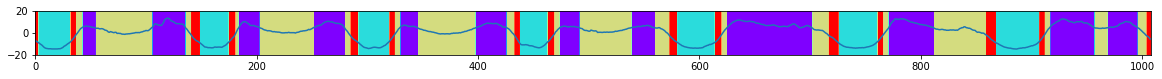

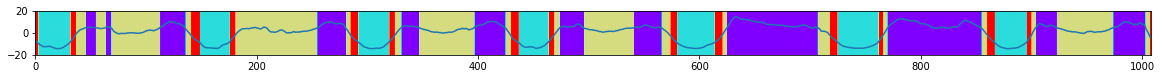

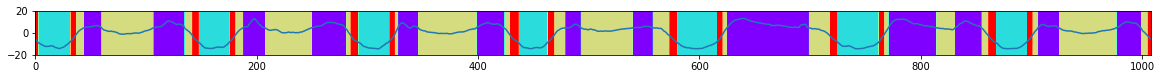

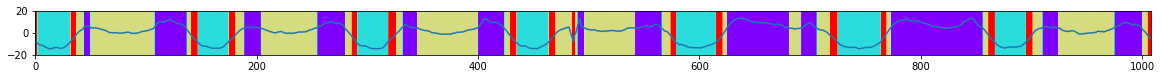

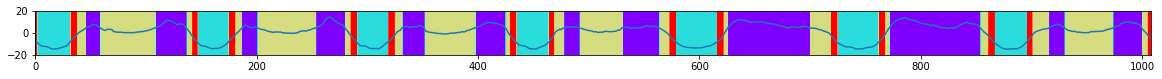

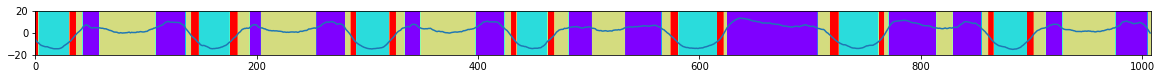

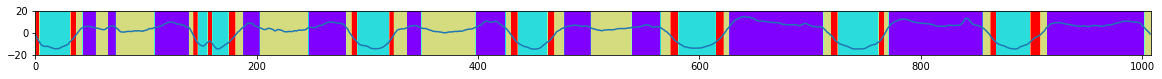

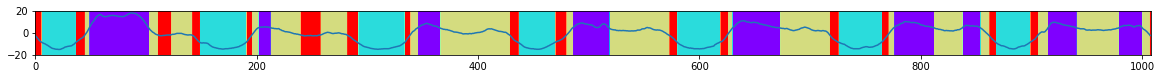

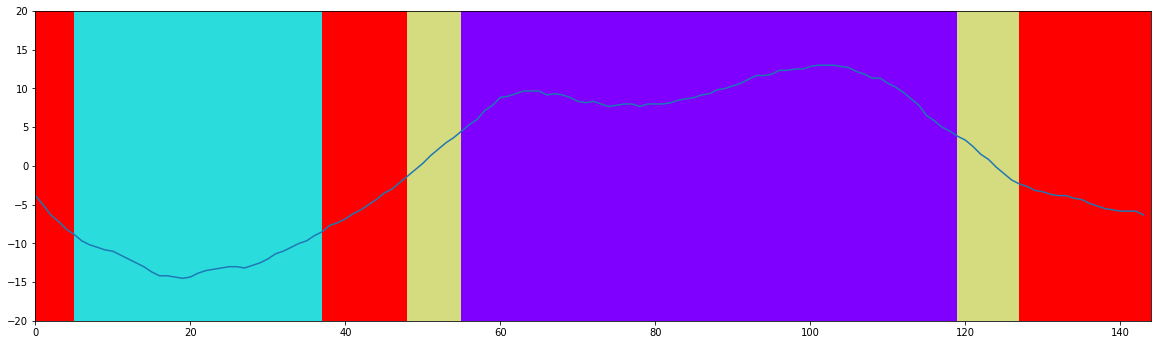

In [157]:
# Predict states
states = densehmm.predict(Y_true).reshape(1, -1)

interval = 7 * 24 * 6

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 20))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.rainbow)
    plt.show()

# Evaluation

## Day/night clustering

In [158]:
representation = densehmm.get_representations()
u_fin, z_fin, z0_fin = representation
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [159]:
kmeans = KMeans(n_clusters=2, random_state=2022).fit(uz_fin)
uz_label = kmeans.labels_
uz_label

array([1, 0, 1, 0], dtype=int32)

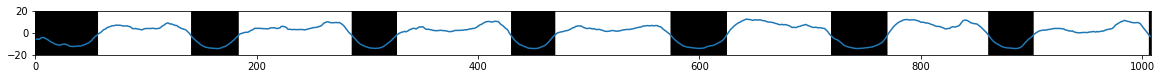

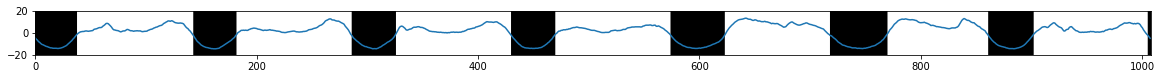

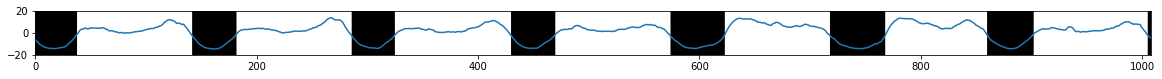

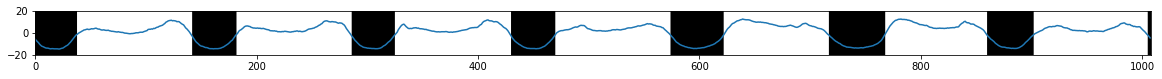

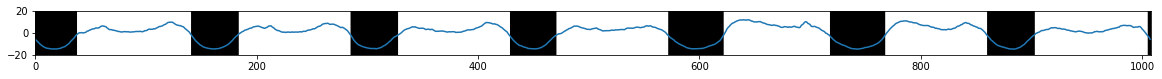

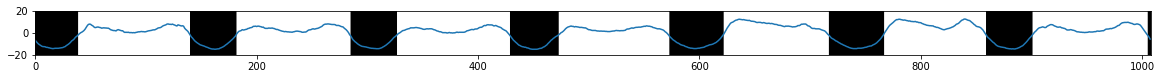

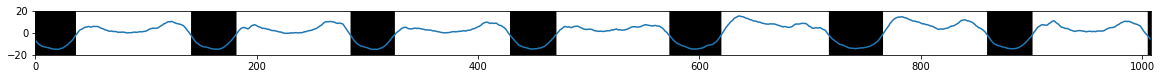

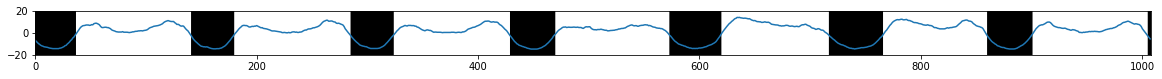

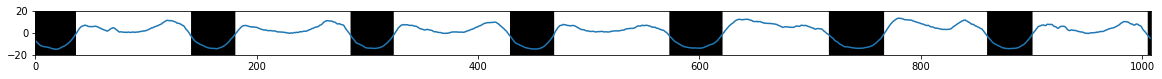

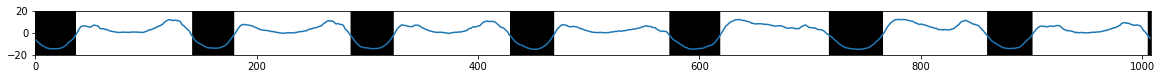

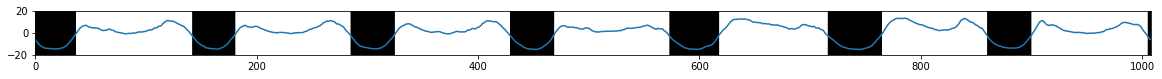

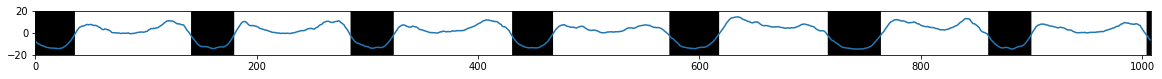

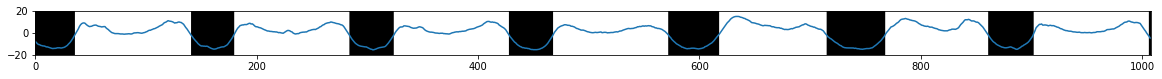

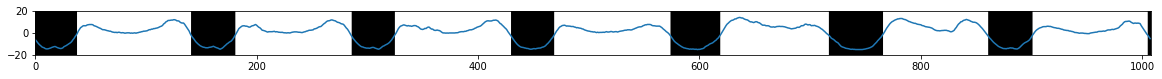

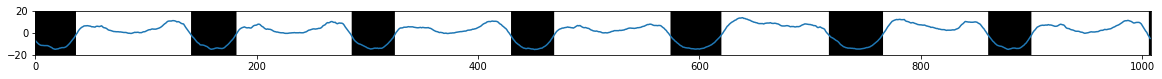

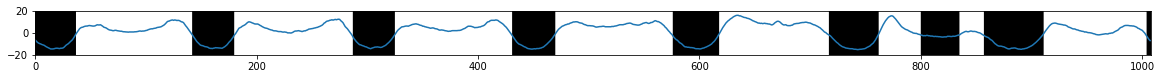

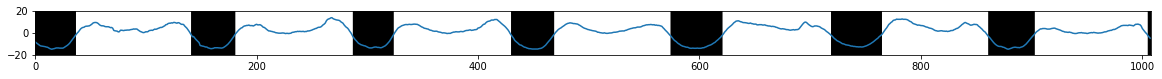

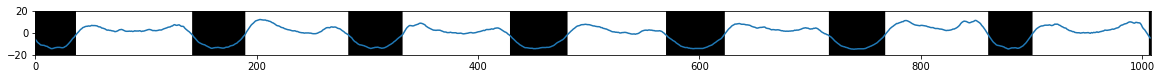

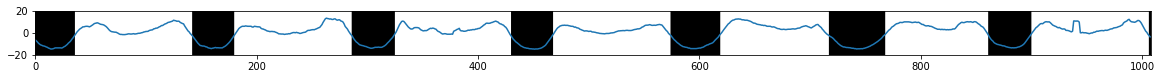

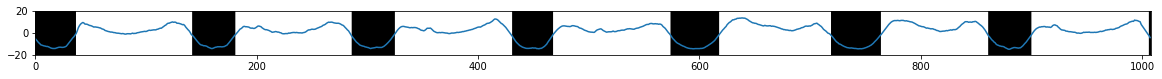

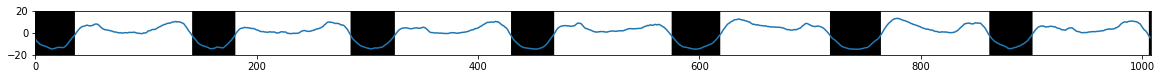

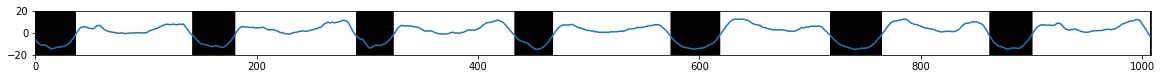

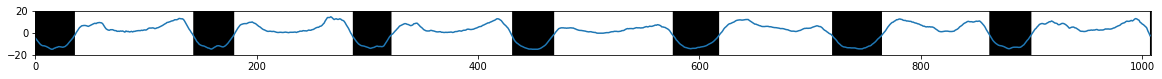

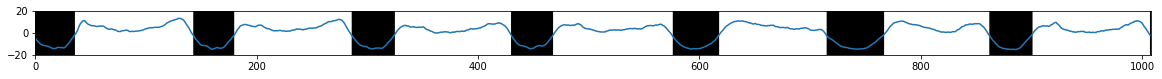

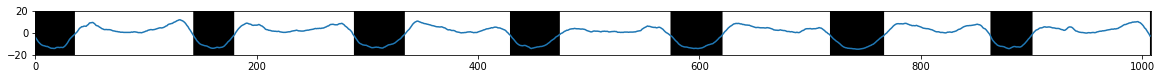

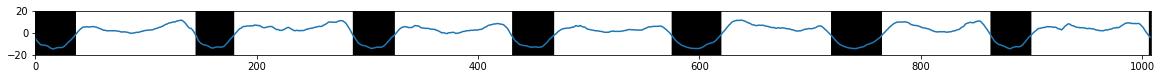

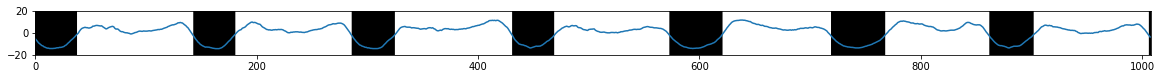

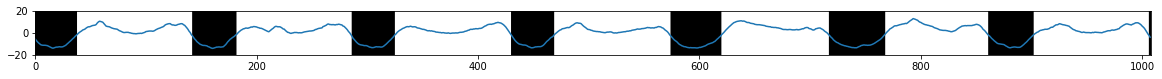

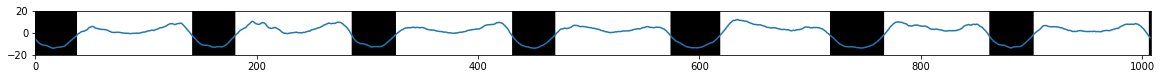

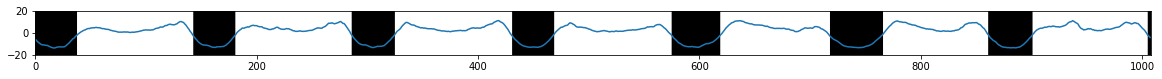

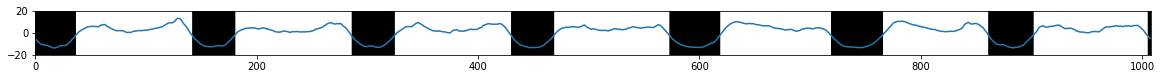

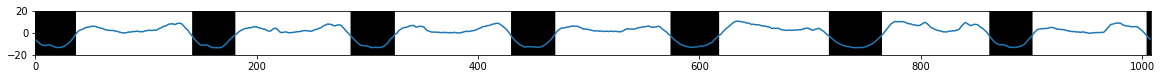

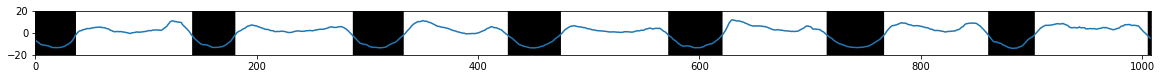

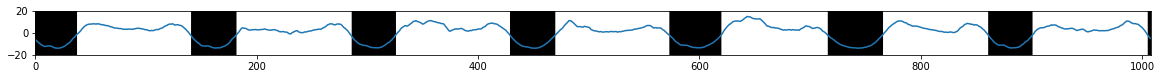

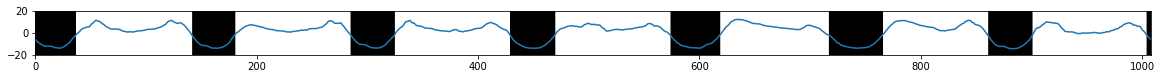

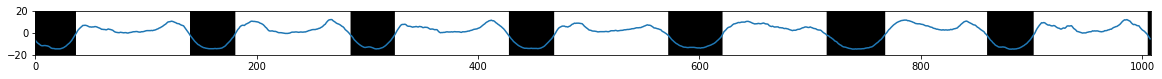

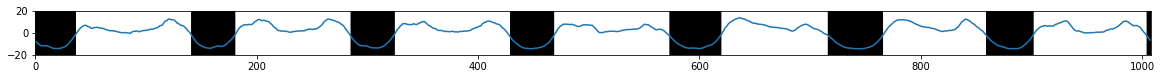

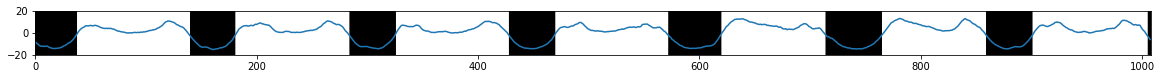

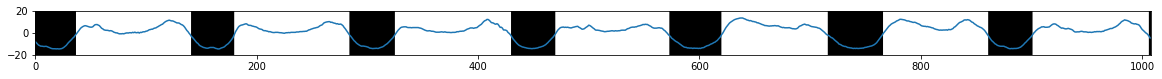

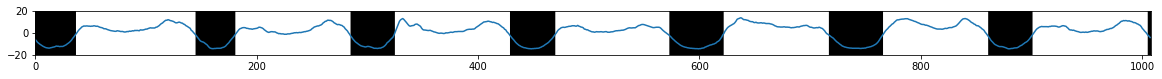

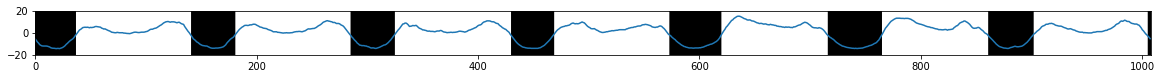

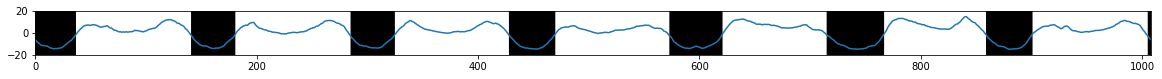

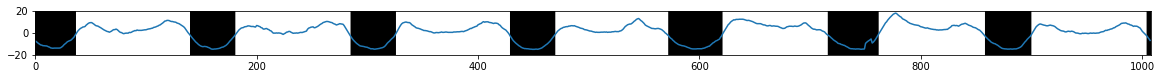

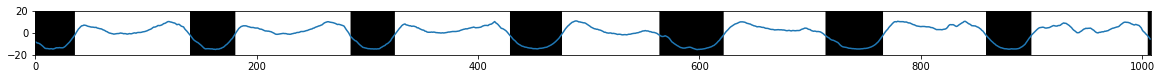

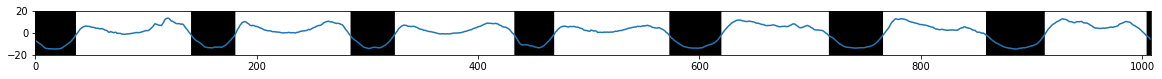

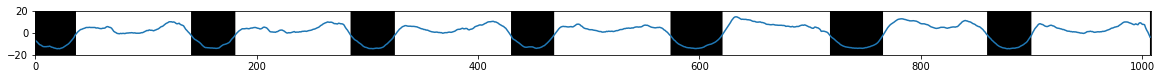

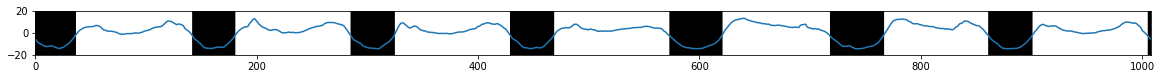

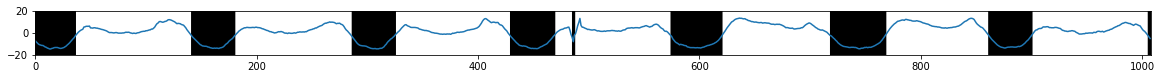

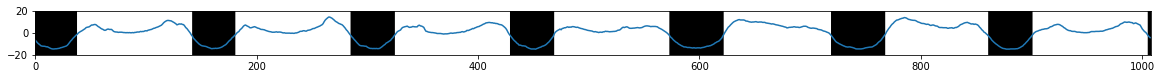

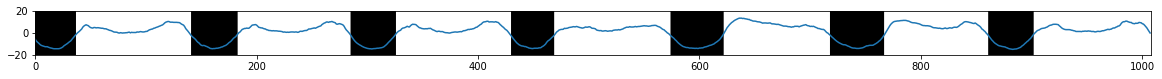

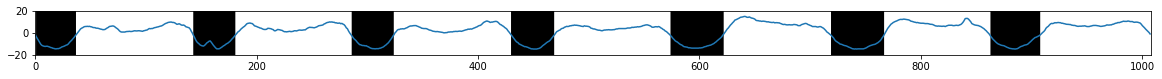

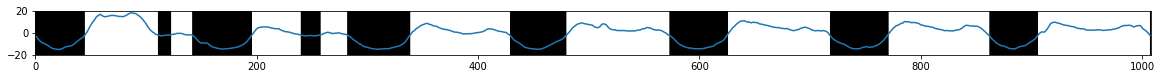

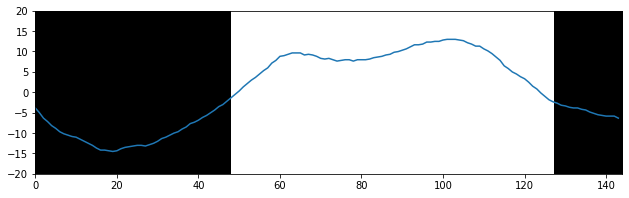

In [259]:
for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 3))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(uz_label[states[:, (i*interval) : ((i+1)*interval)]], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.gray)
    plt.show()

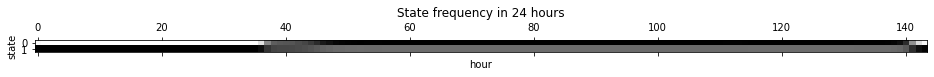

In [161]:
daily = pd.DataFrame({"states": uz_label[states].reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 6) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
daily = daily / daily.sum(axis=1).reshape(-1, 1)

plt.matshow(daily, cmap=cm.gray)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

In [163]:
daily_bin = uz_label[states].reshape(-1, 24*6)
daily_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [166]:
acc_final = 0
c1_final = 0
c2_final = 24*6

for c1 in range(24*6):
    for c2 in range(c1+1, 24*6):
        acc_tmp =  ((daily_bin[:, :c1] == 0).sum() + (daily_bin[:, c1:c2] == 1).sum() + (daily_bin[:, c2:] == 0).sum()) / (365 * 24 * 6)
        if acc_tmp > acc_final:
            acc_final = acc_tmp
            c1_final = c1
            c2_final = c2

print(f"accuracy: {acc_final} with cutoffs {time_range.values[c1_final]} & {time_range.values[c2_final]}")

accuracy: 0.9700152207001522 with cutoffs ['2019-01-01T06:20:00.000000000'] & ['2019-01-01T23:30:00.000000000']


## Weekday

### clustering

In [248]:
uz_fin[states.reshape(-1), :].reshape((365, -1))

array([[-0.54996313,  1.3804878 , -0.32599968, ..., -0.81209232,
        -0.31488234, -0.22380857],
       [-0.54996313,  1.3804878 , -0.32599968, ..., -0.81209232,
        -0.31488234, -0.22380857],
       [-0.54996313,  1.3804878 , -0.32599968, ..., -0.81209232,
        -0.31488234, -0.22380857],
       ...,
       [-0.54996313,  1.3804878 , -0.32599968, ..., -0.81209232,
        -0.31488234, -0.22380857],
       [-0.54996313,  1.3804878 , -0.32599968, ..., -0.81209232,
        -0.31488234, -0.22380857],
       [-0.54996313,  1.3804878 , -0.32599968, ..., -0.81209232,
        -0.31488234, -0.22380857]])

In [252]:
kmeans_Y = KMeans(n_clusters=2, random_state=2022).fit(Y_true.reshape(-1, 24*6))
kmeans_s = KMeans(n_clusters=2, random_state=2022).fit(states.reshape(-1, 24*6))
kmeans_e = KMeans(n_clusters=2, random_state=2022).fit(uz_fin[states.reshape(-1), :].reshape((365, -1)))

In [253]:
target = pd.Series(pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').min(), df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').max(), 365)).apply(lambda d: (d in holidays.PL()) | (d.weekday() > 4))

In [254]:
target

0       True
1      False
2      False
3      False
4       True
       ...  
360    False
361     True
362     True
363    False
364    False
Length: 365, dtype: bool

In [255]:
(kmeans_Y.labels_ == target).mean()

0.9808219178082191

In [256]:
(kmeans_s.labels_ == target).mean()

0.9726027397260274

In [257]:
(kmeans_e.labels_ == target).mean()

0.9753424657534246